# 🏎️ Model 2A : Light GBM - Multi Target Classification


## Step 1 : Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json
import joblib
from datetime import datetime

import warnings
warnings.filterwarnings('ignore')

import lightgbm as lgb

from sklearn.model_selection import (
    RandomizedSearchCV,
    StratifiedKFold,
    learning_curve 
)
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    confusion_matrix,
    make_scorer
)

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

print(" All libraries imported successfully!")

 All libraries imported successfully!


## Step 2 : Load Data

In [12]:
print(" Loading processed data...")


train_df = pd.read_parquet('../data/processed/train_data_v2.parquet')
test_df = pd.read_parquet('../data/processed/test_data_v2.parquet')


train_weights = np.load('../data/processed/train_weights.npy')
test_weights = np.load('../data/processed/test_weights.npy')


with open('../data/processed/metadata_v2.json', 'r') as f:
    metadata = json.load(f)

print(f"\n✅ Data loaded successfully!")
print(f"   Training samples: {len(train_df)} (2024 season)")
print(f"   Test samples: {len(test_df)} (2025 season)")
print(f"   Features: {len(metadata['feature_columns'])}")

 Loading processed data...

✅ Data loaded successfully!
   Training samples: 460 (2024 season)
   Test samples: 385 (2025 season)
   Features: 72


## Step 3 : Prepare features and targets

In [29]:
feature_cols = metadata['feature_columns']

classification_targets = ['win', 'podium', 'points_finish', 'top5']

X_train = train_df[feature_cols]
X_test = test_df[feature_cols]

y_train_class = train_df[classification_targets]
y_test_class = test_df[classification_targets]

X_train = X_train.loc[:, ~X_train.columns.duplicated()]
X_test = X_test.loc[:, ~X_test.columns.duplicated()]
feature_cols = X_train.columns.tolist()

print(f"\nData prepared!")
print(f"\nClass Imbalance Analysis (Training):")
for target in classification_targets:
    pos_count = train_df[target].sum()
    neg_count = len(train_df) - pos_count
    imbalance_ratio = neg_count / pos_count if pos_count > 0 else 0
    print(f"   {target:15s}: {pos_count:4d} positive ({pos_count/len(train_df)*100:5.1f}%) | "
          f"{neg_count:4d} negative | Ratio: 1:{imbalance_ratio:.1f}")


Data prepared!

Class Imbalance Analysis (Training):
   win            :   24 positive (  5.2%) |  436 negative | Ratio: 1:18.2
   podium         :   72 positive ( 15.7%) |  388 negative | Ratio: 1:5.4
   points_finish  :  234 positive ( 50.9%) |  226 negative | Ratio: 1:1.0
   top5           :  120 positive ( 26.1%) |  340 negative | Ratio: 1:2.8


## Step 4 : Define Evaluate functions

In [14]:
def calculate_classification_metrics(y_true, y_pred, y_prob=None, weights=None):
   
    acc = accuracy_score(y_true, y_pred, sample_weight=weights)
    prec = precision_score(y_true, y_pred, sample_weight=weights, zero_division=0)
    rec = recall_score(y_true, y_pred, sample_weight=weights, zero_division=0)
    f1 = f1_score(y_true, y_pred, sample_weight=weights, zero_division=0)
    auc = roc_auc_score(y_true, y_prob, sample_weight=weights) if y_prob is not None else None
    
    return {
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1': f1,
        'AUC': auc
    }


def find_optimal_threshold(y_true, y_prob, weights=None):
    
    thresholds = np.arange(0.1, 0.9, 0.05)
    best_f1 = 0
    best_threshold = 0.5
    
    for thresh in thresholds:
        y_pred = (y_prob >= thresh).astype(int)
        f1 = f1_score(y_true, y_pred, sample_weight=weights, zero_division=0)
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = thresh
    
    return best_threshold, best_f1


def plot_learning_curve(model, X, y, weights=None, cv=5, title="Learning Curve"):

    fit_params = {'sample_weight': weights} if weights is not None else None
    
    train_sizes, train_scores, val_scores = learning_curve(
        model, X, y, 
        train_sizes=np.linspace(0.1, 1.0, 10),
        cv=cv,
        n_jobs=-1,
        scoring='f1' if hasattr(y, 'unique') and len(np.unique(y)) == 2 else 'neg_mean_absolute_error',
        fit_params= fit_params
    )   
    
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)
    val_std = np.std(val_scores, axis=1)
    
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_mean, label='Training score', color='#3671C6', marker='o')
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2, color='#3671C6')
    plt.plot(train_sizes, val_mean, label='CV score', color='#E10600', marker='s')
    plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.2, color='#E10600')
    plt.xlabel('Training Set Size', fontsize=12)
    plt.ylabel('Score', fontsize=12)
    plt.title(title, fontweight='bold', fontsize=14)
    plt.legend(fontsize=10)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

print("Evaluation functions defined!")

Evaluation functions defined!


## Step 5 : Baseline Classification Model

In [20]:
baseline_class_params = {
    'objective': 'binary',        
    'metric': 'binary_logloss',   
    'boosting_type': 'gbdt',
    'n_estimators': 1000,         
    'max_depth': 8,               
    'learning_rate': 0.05,        
    'num_leaves': 20,             
    'min_child_samples': 20,     
    'subsample': 0.8,             
    'colsample_bytree': 0.8,      
    'reg_alpha': 0.1,             
    'reg_lambda': 0.1,            
    'class_weight': 'balanced',   
    'random_state': 42,
    'verbose': -1,
    'n_jobs': -1
}

print("\nConservative Baseline Parameters:")
for param, value in baseline_class_params.items():
    if param not in ['random_state', 'verbose', 'n_jobs', 'objective', 'metric']:
        print(f"   {param}: {value}")

baseline_class_models = {}
baseline_class_results = {}


for target in classification_targets:
    print("-"*80)
    print(f"\n  Training baseline LightGBM classifier for '{target}'...")
    
    model = lgb.LGBMClassifier(**baseline_class_params)
    

    model.fit(
        X_train, y_train_class[target],
        sample_weight=train_weights,
        eval_set=[(X_test, y_test_class[target])],      
        eval_sample_weight=[test_weights],
        callbacks=[lgb.early_stopping(stopping_rounds=50, verbose=False)] 
    )
    
    
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)
    train_prob = model.predict_proba(X_train)[:, 1]
    test_prob = model.predict_proba(X_test)[:, 1]
    
    
    optimal_thresh, optimal_f1 = find_optimal_threshold(
        y_test_class[target], test_prob, test_weights
    )
    test_pred_optimized = (test_prob >= optimal_thresh).astype(int)
    
    
    train_metrics = calculate_classification_metrics(
        y_train_class[target], train_pred, train_prob, train_weights
    )
    test_metrics = calculate_classification_metrics(
        y_test_class[target], test_pred, test_prob, test_weights
    )
    test_metrics_optimized = calculate_classification_metrics(
        y_test_class[target], test_pred_optimized, test_prob, test_weights
    )
    
    
    baseline_class_models[target] = model
    baseline_class_results[target] = {
        'train_metrics': train_metrics,
        'test_metrics': test_metrics,
        'test_metrics_optimized': test_metrics_optimized,
        'train_pred': train_pred,
        'test_pred': test_pred,
        'test_pred_optimized': test_pred_optimized,
        'train_prob': train_prob,
        'test_prob': test_prob,
        'optimal_threshold': optimal_thresh,
        'best_iteration': model.best_iteration_
    }
    
    
    print(f" Results for '{target}':")
    print(f"   Default Threshold (0.50)")
    print(f"      ➤ F1 Score : {test_metrics['F1']:.3f}")
    print(f"      ➤ ROC AUC  : {test_metrics['AUC']:.3f}")
    print(f"   Optimized Threshold ({optimal_thresh:.2f})")
    print(f"      ➤ F1 Score : {test_metrics_optimized['F1']:.3f}")
    print(f"      ➤ ROC AUC  : {test_metrics_optimized['AUC']:.3f}")

    
print("-"*80)
print("\n✅ All baseline models trained with early stopping!")


Conservative Baseline Parameters:
   boosting_type: gbdt
   n_estimators: 1000
   max_depth: 8
   learning_rate: 0.05
   num_leaves: 20
   min_child_samples: 20
   subsample: 0.8
   colsample_bytree: 0.8
   reg_alpha: 0.1
   reg_lambda: 0.1
   class_weight: balanced
--------------------------------------------------------------------------------

  Training baseline LightGBM classifier for 'win'...
 Results for 'win':
   Default Threshold (0.50)
      ➤ F1 Score : 0.546
      ➤ ROC AUC  : 0.962
   Optimized Threshold (0.70)
      ➤ F1 Score : 0.572
      ➤ ROC AUC  : 0.962
--------------------------------------------------------------------------------

  Training baseline LightGBM classifier for 'podium'...
 Results for 'podium':
   Default Threshold (0.50)
      ➤ F1 Score : 0.728
      ➤ ROC AUC  : 0.950
   Optimized Threshold (0.70)
      ➤ F1 Score : 0.753
      ➤ ROC AUC  : 0.950
--------------------------------------------------------------------------------

  Training baselin

## Step 6 : Analyse Learning Curves


 Analyzing 'win'...


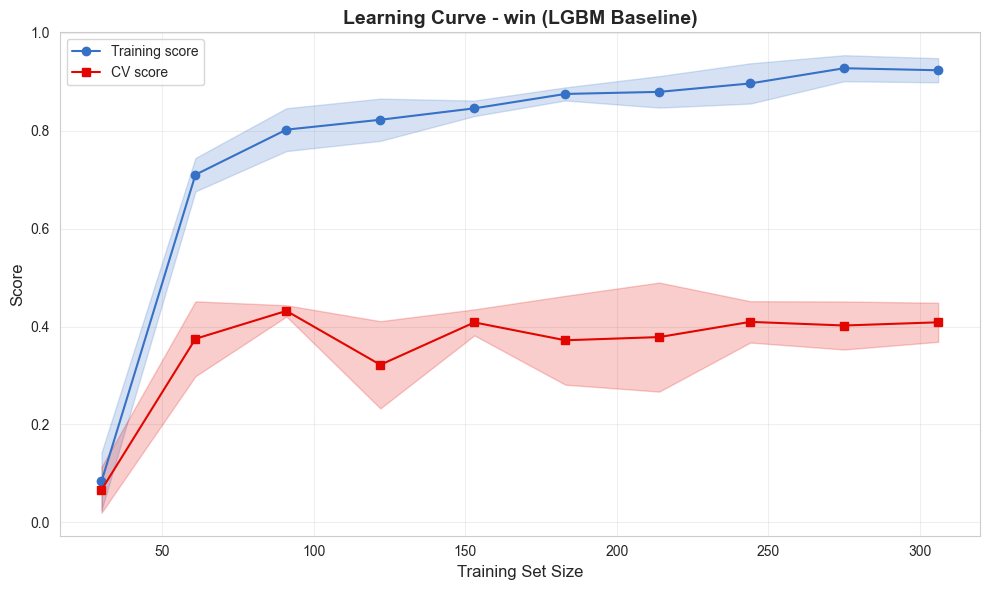


 Analyzing 'podium'...


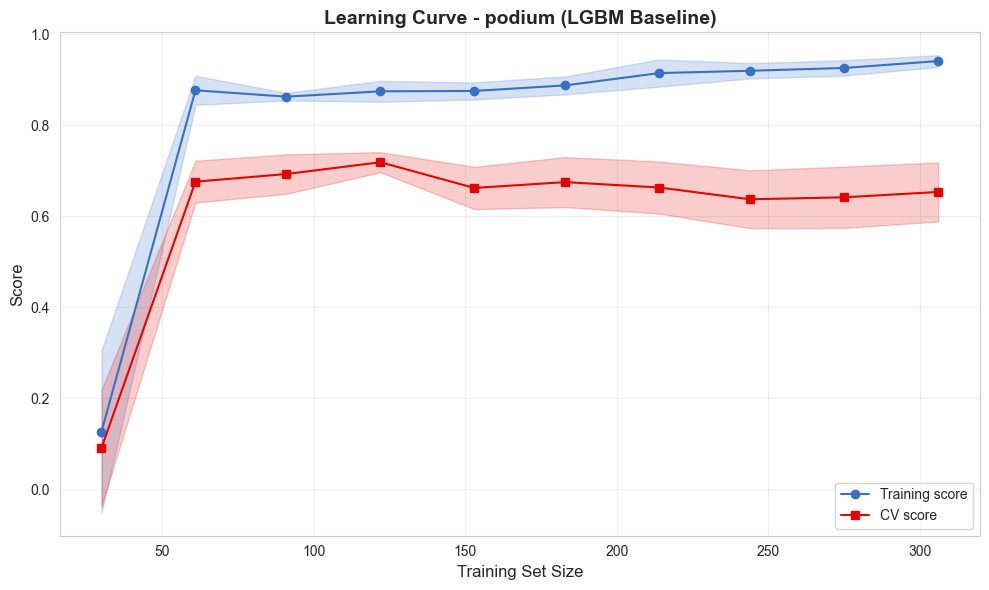


 Analyzing 'points_finish'...


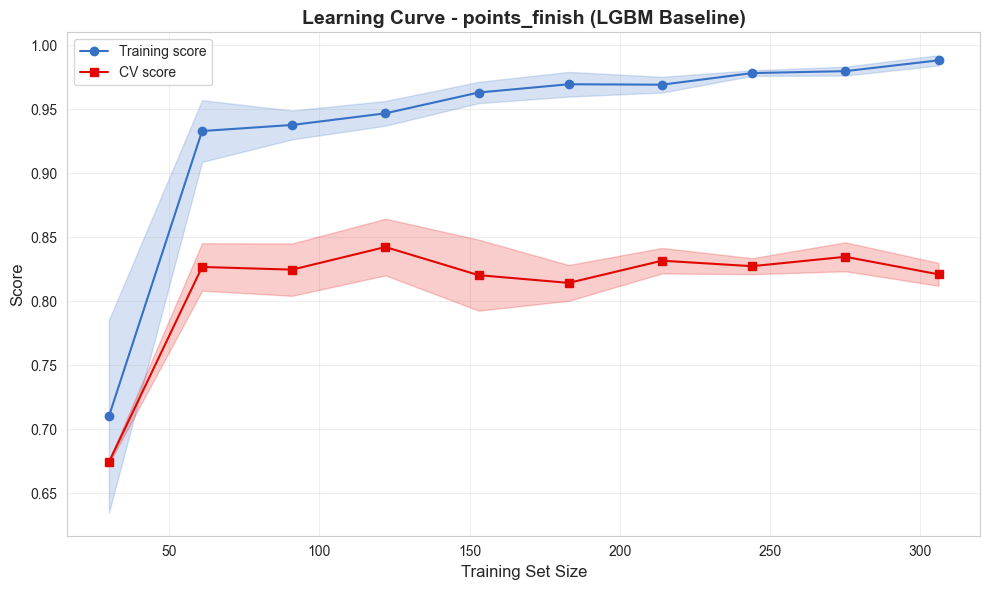


 Analyzing 'top5'...


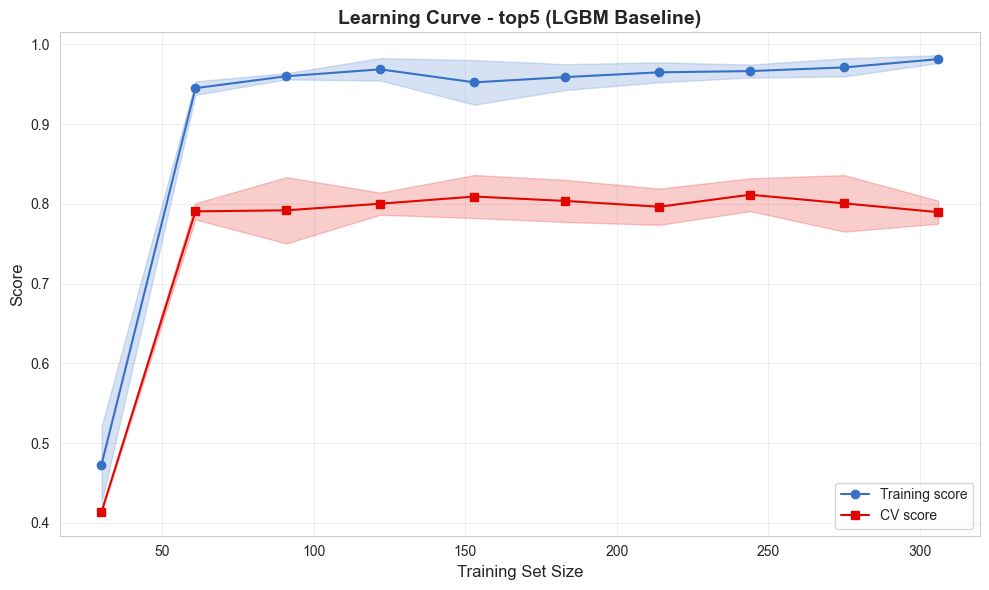

Learning curve analysis complete!


In [21]:
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

for target in classification_targets:
    print(f"\n Analyzing '{target}'...")
    temp_model = lgb.LGBMClassifier(**baseline_class_params)
    
    plot_learning_curve(
        temp_model,
        X_train,
        y_train_class[target],
        weights=train_weights,
        cv=skf,
        title=f"Learning Curve - {target} (LGBM Baseline)"
    )

print("Learning curve analysis complete!")

## Step 7 : Optimized Hyperparameter Search

In [23]:
class_param_grid = {
    'n_estimators': [200, 300, 500, 700],
    'max_depth': [8, 10, 12, 15],
    'learning_rate': [0.01, 0.03, 0.05, 0.1], 
    'num_leaves': [20, 31, 40, 50],       
    'min_child_samples': [15, 20, 25, 30],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.6, 0.7, 0.8],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [0, 0.1, 0.5],
    'class_weight': ['balanced']
}

print("\n Careful Search Space (LGBM):")
print(f"   learning_rate: {class_param_grid['learning_rate']}")
print(f"   num_leaves: {class_param_grid['num_leaves']}")
print(f"   max_depth: {class_param_grid['max_depth']}")
print(f"   n_estimators: {class_param_grid['n_estimators']}")

optimized_class_models = {}
optimized_class_results = {}
cv_results_class = {}

for target in classification_targets:
    print(f"\n Optimizing target: '{target}' using StratifiedKFold cross-validation...")
    print("-"*70)
    

    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    
    
    f1_scorer = make_scorer(f1_score, zero_division=0)
    
    random_search = RandomizedSearchCV(
        estimator=lgb.LGBMClassifier(
            objective='binary',
            boosting_type='gbdt',
            random_state=42, 
            n_jobs=-1,
            verbose=-1
        ),
        param_distributions=class_param_grid,
        n_iter=30,  
        scoring=f1_scorer,
        cv=skf,
        verbose=1,
        random_state=42,
        n_jobs=-1
    )
    
    random_search.fit(X_train, y_train_class[target], sample_weight=train_weights)
    
    
    best_params = random_search.best_params_
    
    
    best_model_optimized = lgb.LGBMClassifier(
        objective='binary',
        boosting_type='gbdt',
        random_state=42, 
        n_jobs=-1,
        verbose=-1,
        **best_params  
    )
    
    best_model_optimized.fit(
        X_train, y_train_class[target],
        sample_weight=train_weights,
        eval_set=[(X_test, y_test_class[target])],
        eval_sample_weight=[test_weights],
        callbacks=[lgb.early_stopping(stopping_rounds=50, verbose=False)]
    )
    
    
    train_pred = best_model_optimized.predict(X_train)
    test_pred = best_model_optimized.predict(X_test)
    train_prob = best_model_optimized.predict_proba(X_train)[:, 1]
    test_prob = best_model_optimized.predict_proba(X_test)[:, 1]
    
    
    optimal_thresh, optimal_f1 = find_optimal_threshold(
        y_test_class[target], test_prob, test_weights
    )
    test_pred_optimized = (test_prob >= optimal_thresh).astype(int)
    
    
    train_metrics = calculate_classification_metrics(
        y_train_class[target], train_pred, train_prob, train_weights
    )
    test_metrics = calculate_classification_metrics(
        y_test_class[target], test_pred, test_prob, test_weights
    )
    test_metrics_optimized = calculate_classification_metrics(
        y_test_class[target], test_pred_optimized, test_prob, test_weights
    )
    
    
    optimized_class_models[target] = best_model_optimized
    optimized_class_results[target] = {
        'train_metrics': train_metrics,
        'test_metrics': test_metrics,
        'test_metrics_optimized': test_metrics_optimized,
        'train_pred': train_pred,
        'test_pred': test_pred,
        'test_pred_optimized': test_pred_optimized,
        'train_prob': train_prob,
        'test_prob': test_prob,
        'best_params': best_params,
        'optimal_threshold': optimal_thresh,
        'best_iteration': best_model_optimized.best_iteration_
    }
    cv_results_class[target] = pd.DataFrame(random_search.cv_results_)
    
    print(f"    Best CV F1 Score:          {random_search.best_score_:.3f}")
    print(f"    Test F1 (Optimized):       {test_metrics_optimized['F1']:.3f}")
    print(f"    Best Parameters → depth={random_search.best_params_['max_depth']}, "
          f"n_estimators={random_search.best_params_['n_estimators']}, "
          f"threshold={optimal_thresh:.3f}")

print("\n All models optimized with careful tuning!")


 Careful Search Space (LGBM):
   learning_rate: [0.01, 0.03, 0.05, 0.1]
   num_leaves: [20, 31, 40, 50]
   max_depth: [8, 10, 12, 15]
   n_estimators: [200, 300, 500, 700]

 Optimizing target: 'win' using StratifiedKFold cross-validation...
----------------------------------------------------------------------
Fitting 3 folds for each of 30 candidates, totalling 90 fits
    Best CV F1 Score:          0.479
    Test F1 (Optimized):       0.598
    Best Parameters → depth=8, n_estimators=700, threshold=0.750

 Optimizing target: 'podium' using StratifiedKFold cross-validation...
----------------------------------------------------------------------
Fitting 3 folds for each of 30 candidates, totalling 90 fits
    Best CV F1 Score:          0.667
    Test F1 (Optimized):       0.753
    Best Parameters → depth=15, n_estimators=200, threshold=0.500

 Optimizing target: 'points_finish' using StratifiedKFold cross-validation...
----------------------------------------------------------------

## Step 8 : Comparision

In [25]:
comparison_data = []

for target in classification_targets:
    baseline = baseline_class_results[target]['test_metrics_optimized']
    optimized = optimized_class_results[target]['test_metrics_optimized']
    baseline_default = baseline_class_results[target]['test_metrics']
    
    row = {
        'Target': target,
        'Baseline_F1_default': baseline_default['F1'],
        'Baseline_F1_optimized': baseline['F1'],
        'Optimized_F1': optimized['F1'],
        'Baseline_AUC': baseline['AUC'],
        'Optimized_AUC': optimized['AUC'],
        'Improvement': ((optimized['F1'] - baseline['F1']) / baseline['F1'] * 100) if baseline['F1'] > 0 else 0
    }
    comparison_data.append(row)

comparison_df = pd.DataFrame(comparison_data)

print("\nDetailed Comparison:")
display(comparison_df)

print("\n💡 ANALYSIS:")
for _, row in comparison_df.iterrows():
    target = row['Target']
    baseline_opt_f1 = row['Baseline_F1_optimized']
    optimized_f1 = row['Optimized_F1']
    
    if optimized_f1 > baseline_opt_f1:
        print(f"   ✅ {target}: Optimized BETTER by {row['Improvement']:.1f}% "
              f"(F1: {baseline_opt_f1:.3f} → {optimized_f1:.3f})")
    elif abs(optimized_f1 - baseline_opt_f1) < 0.01:
        print(f"   ≈  {target}: Similar performance (F1: {baseline_opt_f1:.3f} vs {optimized_f1:.3f})")
    else:
        print(f"   ⚠️  {target}: Baseline BETTER (F1: {baseline_opt_f1:.3f} vs {optimized_f1:.3f})")



Detailed Comparison:


,Target,Baseline_F1_default,Baseline_F1_optimized,Optimized_F1,Baseline_AUC,Optimized_AUC,Improvement
0,win,0.546228,0.571758,0.597771,0.961646,0.964288,4.549619
1,podium,0.727851,0.753209,0.752812,0.949845,0.952776,-0.052713
2,points_finish,0.781327,0.792129,0.802514,0.838015,0.838441,1.311052
3,top5,0.775098,0.781369,0.783841,0.912072,0.910972,0.316401



💡 ANALYSIS:
   ✅ win: Optimized BETTER by 4.5% (F1: 0.572 → 0.598)
   ≈  podium: Similar performance (F1: 0.753 vs 0.753)
   ✅ points_finish: Optimized BETTER by 1.3% (F1: 0.792 → 0.803)
   ✅ top5: Optimized BETTER by 0.3% (F1: 0.781 → 0.784)


## Step 9 : Visaualisation

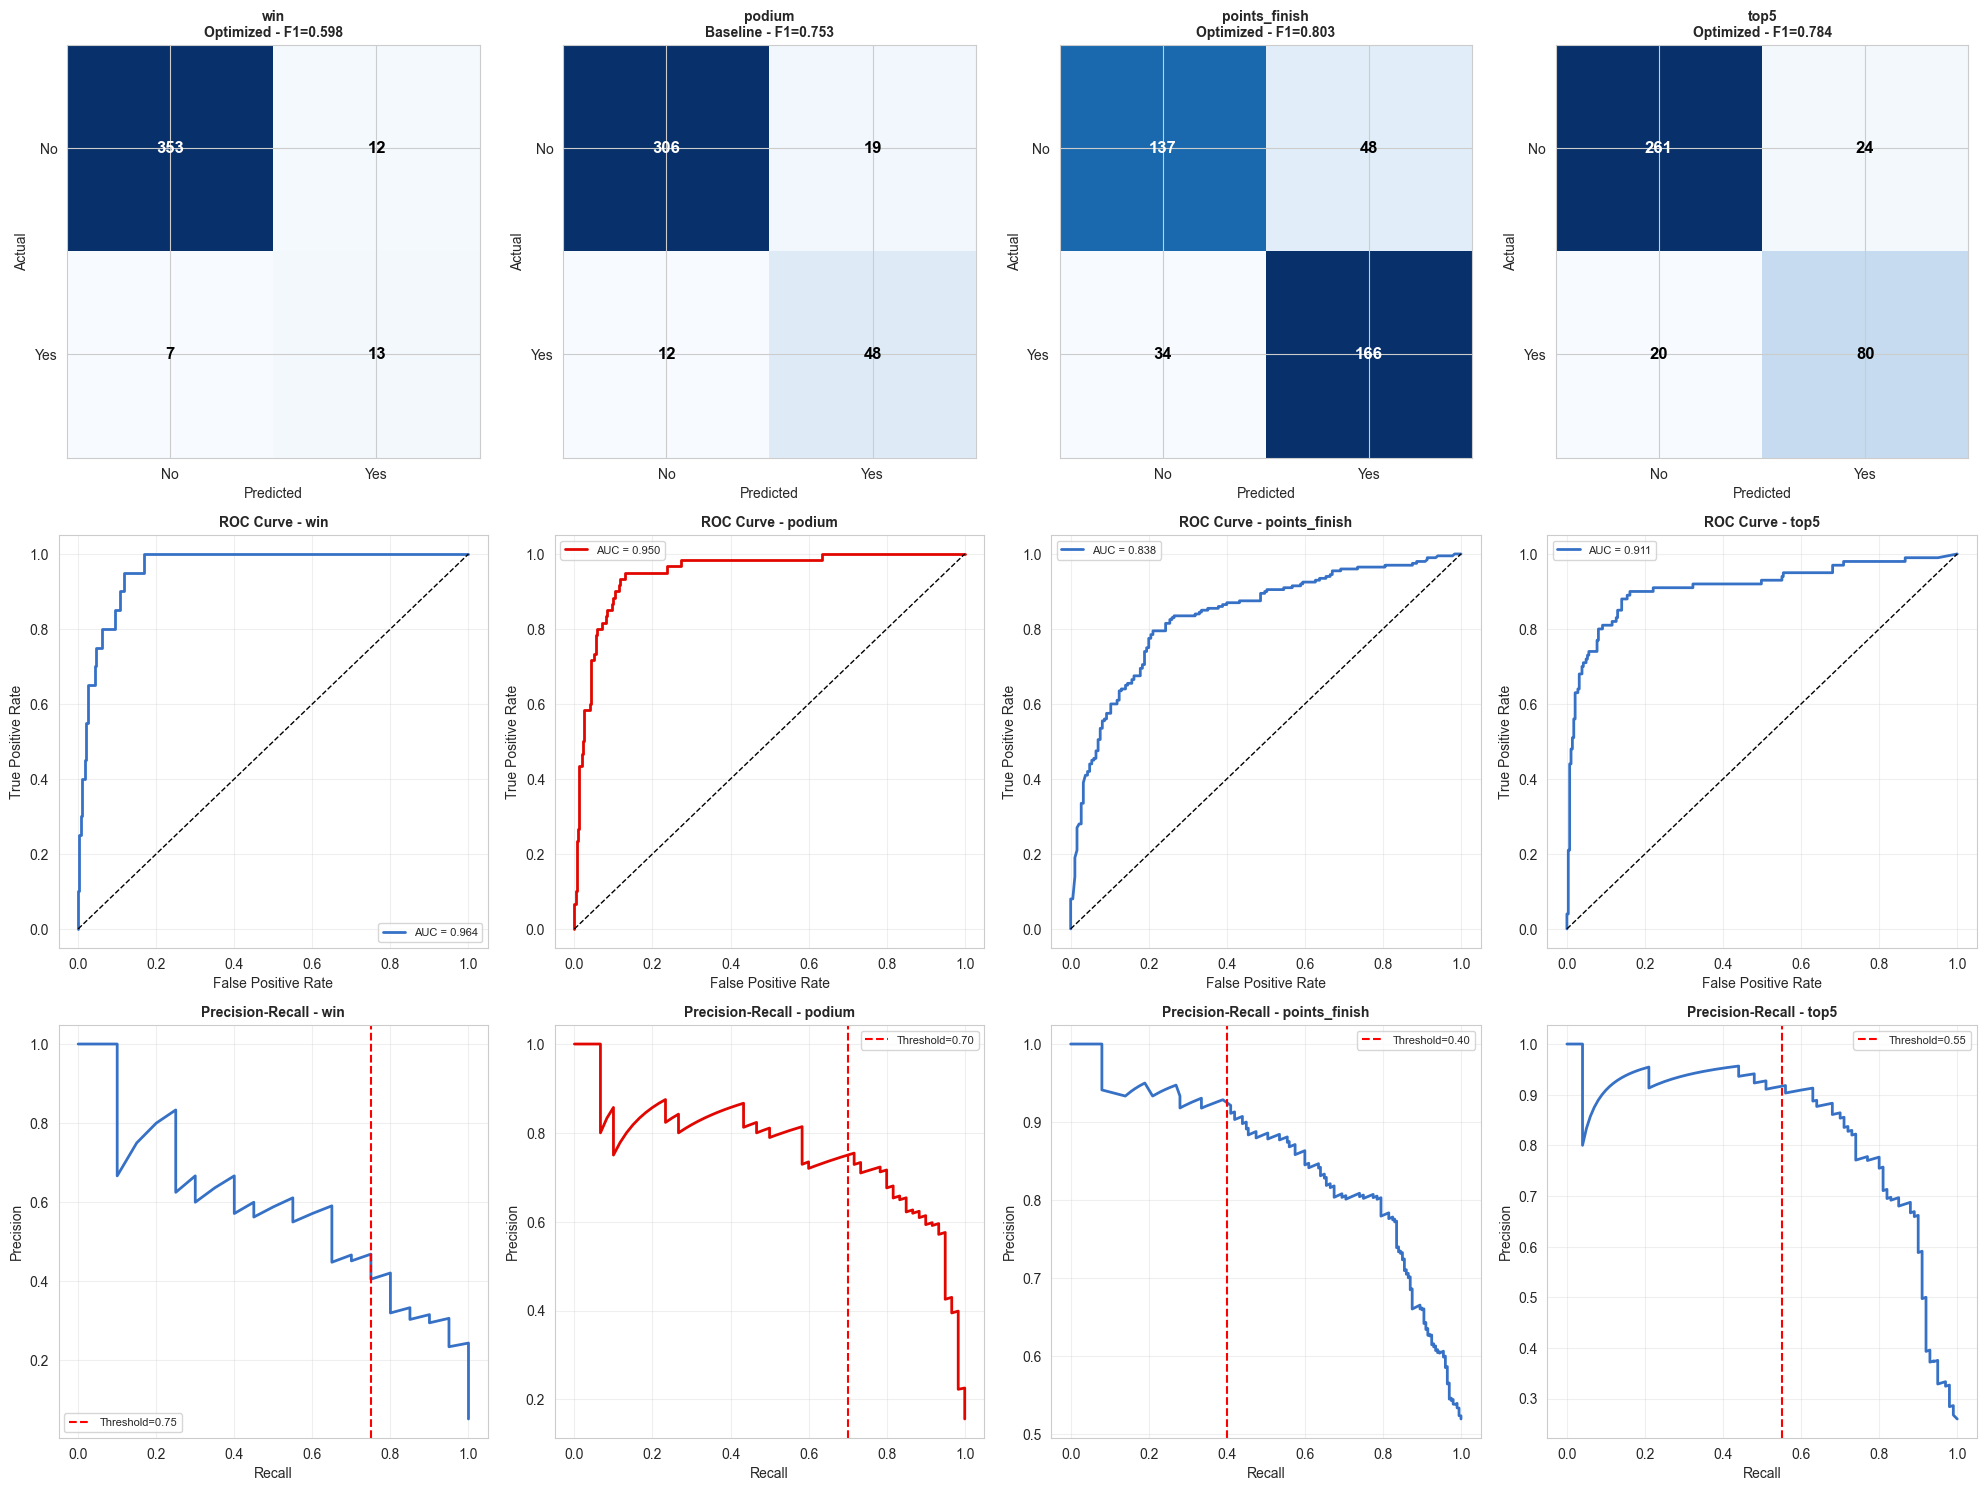

 Detailed visualizations complete!


In [26]:
fig, axes = plt.subplots(3, 4, figsize=(20, 15))

for idx, target in enumerate(classification_targets):
    
    baseline_f1 = baseline_class_results[target]['test_metrics_optimized']['F1']
    optimized_f1 = optimized_class_results[target]['test_metrics_optimized']['F1']
    
    if optimized_f1 > baseline_f1:
        best_results = optimized_class_results[target]
        model_label = "Optimized"
        color = '#3671C6'
    else:
        best_results = baseline_class_results[target]
        model_label = "Baseline"
        color = '#E10600'
    
    
    cm = confusion_matrix(y_test_class[target], best_results['test_pred_optimized'])
    axes[0, idx].imshow(cm, cmap='Blues')
    axes[0, idx].set_title(f'{target}\n{model_label} - F1={best_results["test_metrics_optimized"]["F1"]:.3f}', 
                           fontweight='bold', fontsize=10)
    axes[0, idx].set_xlabel('Predicted')
    axes[0, idx].set_ylabel('Actual')
    axes[0, idx].set_xticks([0, 1])
    axes[0, idx].set_yticks([0, 1])
    axes[0, idx].set_xticklabels(['No', 'Yes'])
    axes[0, idx].set_yticklabels(['No', 'Yes'])
    
    for i in range(2):
        for j in range(2):
            axes[0, idx].text(j, i, str(cm[i, j]), ha='center', va='center',
                             color='white' if cm[i, j] > cm.max()/2 else 'black',
                             fontsize=12, fontweight='bold')
    
    
    fpr, tpr, _ = roc_curve(y_test_class[target], best_results['test_prob'])
    axes[1, idx].plot(fpr, tpr, color=color, lw=2, 
                     label=f'AUC = {best_results["test_metrics_optimized"]["AUC"]:.3f}')
    axes[1, idx].plot([0, 1], [0, 1], 'k--', lw=1)
    axes[1, idx].set_xlabel('False Positive Rate')
    axes[1, idx].set_ylabel('True Positive Rate')
    axes[1, idx].set_title(f'ROC Curve - {target}', fontweight='bold', fontsize=10)
    axes[1, idx].legend(fontsize=8)
    axes[1, idx].grid(alpha=0.3)
    
    
    precision, recall, thresholds = precision_recall_curve(
        y_test_class[target], best_results['test_prob']
    )
    axes[2, idx].plot(recall, precision, color=color, lw=2)
    axes[2, idx].axvline(best_results['optimal_threshold'], color='red', 
                        linestyle='--', label=f'Threshold={best_results["optimal_threshold"]:.2f}')
    axes[2, idx].set_xlabel('Recall')
    axes[2, idx].set_ylabel('Precision')
    axes[2, idx].set_title(f'Precision-Recall - {target}', fontweight='bold', fontsize=10)
    axes[2, idx].legend(fontsize=8)
    axes[2, idx].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(" Detailed visualizations complete!")

## Step 10 : Feature importance


📊 Analyzing best performer: 'points_finish'

 TOP 15 FEATURES (points_finish - Optimized model):

quali_position                      ████████████████████████████████████████ 225
avg_quali_position_5                ███████████████████████████████ 178
team_weighted_points_5              ███████████████████ 109
q3_gap_to_pole                      ███████████████████ 108
weighted_avg_position_5             ██████████████████ 103
team_weighted_avg_position_5        █████████████████ 96
grid_position                       ████████████████ 91
weighted_points_5                   ███████████████ 86
driver_circuit_weighted_points      █████████████ 77
quali_gap_to_teammate               ████████████ 72
points_to_leader                    █████████ 53
driver_circuit_weighted_pos         ████████ 49
circuit_encoded                     ███████ 40
team_id                             ██████ 34
driver_number                       ████ 27


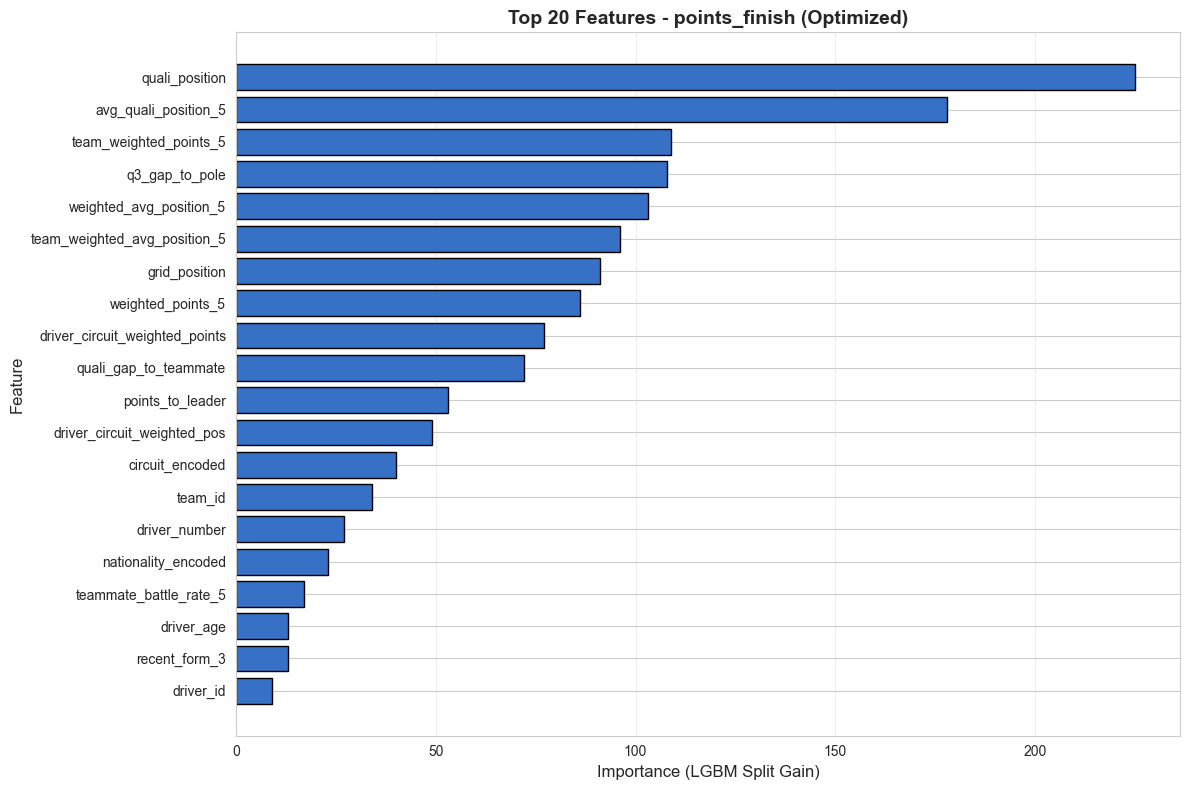

In [32]:
best_target = comparison_df.loc[comparison_df['Optimized_F1'].idxmax(), 'Target']
print(f"\n📊 Analyzing best performer: '{best_target}'")

if optimized_class_results[best_target]['test_metrics_optimized']['F1'] >= \
   baseline_class_results[best_target]['test_metrics_optimized']['F1']:
    best_model = optimized_class_models[best_target]
    model_type = "Optimized"
else:
    best_model = baseline_class_models[best_target]
    model_type = "Baseline"


feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': best_model.feature_importances_
}).sort_values('importance', ascending=False)


print(f"\n TOP 15 FEATURES ({best_target} - {model_type} model):\n")
for idx, row in feature_importance.head(15).iterrows():
    bar = '█' * int(row['importance'] / feature_importance['importance'].max() * 40)
    print(f"{row['feature'][:35]:35s} {bar} {row['importance']:.0f}")


plt.figure(figsize=(12, 8))
top_features = feature_importance.head(20)
plt.barh(range(len(top_features)), top_features['importance'], color='#3671C6', edgecolor='black')
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Importance (LGBM Split Gain)', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title(f'Top 20 Features - {best_target} ({model_type})', fontweight='bold', fontsize=14)
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

## Step 11 : Save Models

In [33]:
os.makedirs('../models', exist_ok=True)
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

saved_files = []

print("\n" + "="*80)
print(" SAVING BEST LIGHTGBM CLASSIFICATION MODELS")
print("="*80)

for target in classification_targets:
    baseline_f1 = baseline_class_results[target]['test_metrics_optimized']['F1']
    optimized_f1 = optimized_class_results[target]['test_metrics_optimized']['F1']
    
    if optimized_f1 >= baseline_f1:
        model_to_save = optimized_class_models[target]
        results = optimized_class_results[target]
        model_type = "Optimized"
    else:
        model_to_save = baseline_class_models[target]
        results = baseline_class_results[target]
        model_type = "Baseline"
    
    
    model_path = f'../models/LGBM_Classifier_{target}_{model_type}_v2_{timestamp}.pkl'
    joblib.dump(model_to_save, model_path)
    saved_files.append(model_path)
    
    print(f"\n {target:15s}: {model_type:10s} | F1={results['test_metrics_optimized']['F1']:.3f} | "
          f"Threshold={results['optimal_threshold']:.2f}")


metadata_dict = {
    'timestamp': datetime.now().isoformat(),
    'version': 'v2_lightgbm',
    'model_family': 'LightGBM',
    'features': feature_cols,
    'classification_targets': classification_targets,
    'models': {}
}

for target in classification_targets:
    baseline_f1 = baseline_class_results[target]['test_metrics_optimized']['F1']
    optimized_f1 = optimized_class_results[target]['test_metrics_optimized']['F1']
    
    if optimized_f1 >= baseline_f1:
        results = optimized_class_results[target]
        model_type = "Optimized"
    else:
        results = baseline_class_results[target]
        model_type = "Baseline"
    
    metadata_dict['models'][target] = {
        'model_type': model_type,
        'test_f1': float(results['test_metrics_optimized']['F1']),
        'test_auc': float(results['test_metrics_optimized']['AUC']),
        'optimal_threshold': float(results['optimal_threshold']),
        'best_iteration': int(results['best_iteration'])
    }

metadata_path = f'../models/LGBM_Classification_Metadata_v2_{timestamp}.json'
with open(metadata_path, 'w') as f:
    json.dump(metadata_dict, f, indent=2)
saved_files.append(metadata_path)


comparison_path = f'../models/LGBM_Classification_Comparison_v2_{timestamp}.csv'
comparison_df.to_csv(comparison_path, index=False)
saved_files.append(comparison_path)


print(f"\n Metadata: {metadata_path}")
print(f" Comparison: {comparison_path}")
print(f"\nAll classification files saved! Total: {len(saved_files)} files")


 SAVING BEST LIGHTGBM CLASSIFICATION MODELS

 win            : Optimized  | F1=0.598 | Threshold=0.75

 podium         : Baseline   | F1=0.753 | Threshold=0.70

 points_finish  : Optimized  | F1=0.803 | Threshold=0.40

 top5           : Optimized  | F1=0.784 | Threshold=0.55

 Metadata: ../models/LGBM_Classification_Metadata_v2_20251102_105608.json
 Comparison: ../models/LGBM_Classification_Comparison_v2_20251102_105608.csv

All classification files saved! Total: 6 files


# Classification Summary

In [36]:
print("\n" + "="*80)
print(" LIGHTGBM CLASSIFICATION - FINAL SUMMARY")
print("="*80)

print("\n BEST MODELS PERFORMANCE (with optimized thresholds):\n")
for target in classification_targets:
    baseline_f1 = baseline_class_results[target]['test_metrics_optimized']['F1']
    optimized_f1 = optimized_class_results[target]['test_metrics_optimized']['F1']
    
    best_f1 = max(baseline_f1, optimized_f1)
    model_type = "Optimized" if optimized_f1 > baseline_f1 else "Baseline"
    results = optimized_class_results[target] if optimized_f1 > baseline_f1 else baseline_class_results[target]
    
    print(f"   {target:15s} | {model_type:10s} | F1: {best_f1:.3f} | "
          f"AUC: {results['test_metrics_optimized']['AUC']:.3f} | "
          f"Acc: {results['test_metrics_optimized']['Accuracy']:.3f} | "
          f"Pre: {results['test_metrics_optimized']['Precision']:.3f} |"
          f"Rec: {results['test_metrics_optimized']['Recall']:.3f} |" )




 LIGHTGBM CLASSIFICATION - FINAL SUMMARY

 BEST MODELS PERFORMANCE (with optimized thresholds):

   win             | Optimized  | F1: 0.598 | AUC: 0.964 | Acc: 0.953 | Pre: 0.544 |Rec: 0.663 |
   podium          | Baseline   | F1: 0.753 | AUC: 0.950 | Acc: 0.918 | Pre: 0.715 |Rec: 0.796 |
   points_finish   | Optimized  | F1: 0.803 | AUC: 0.838 | Acc: 0.787 | Pre: 0.778 |Rec: 0.828 |
   top5            | Optimized  | F1: 0.784 | AUC: 0.911 | Acc: 0.885 | Pre: 0.771 |Rec: 0.797 |
